In [1]:
import numpy as np
np.set_printoptions(threshold=np.inf)
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import normflows as nf
import random
from torch.utils.data import DataLoader
import pandas as pd
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
import pyvinecopulib as pv

from scipy.stats import norm

from GPDFlow import T_mGPD_NF
import Common_Functions as cf
from matplotlib.colors import LinearSegmentedColormap

/home/pgrad2/2448355h/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Using device: cuda


#### Define a GPDFlow

In [2]:
dir_out = "/home/pgrad2/2448355h/My_PhD_Project/01_Output/GPDFlow/"

dim = 2
base = nf.distributions.DiagGaussian(dim)


#### Find a suitable threshold for the simulated data

Text(0.5, 1.0, 'omega')

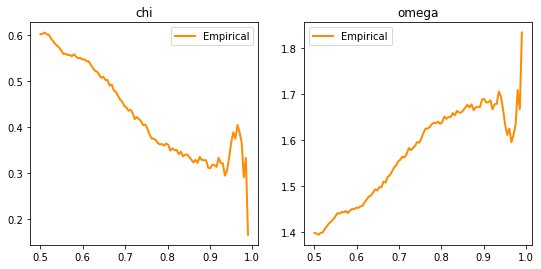

In [3]:


Gumble = pv.Bicop(pv.BicopFamily.gumbel, parameters=np.array([[1.3]]))
cop = Gumble
# print(cop)

U = cop.simulate(1200, seeds = np.array([1234,1235]))

alpha = 2.0
beta  = 1.0  # scale


margin1 = norm.ppf(U[:,0], loc=1, scale=3)
margin2 = norm.ppf(U[:,1], loc=2, scale=5)

samples_origin = np.stack([margin1,margin2],axis=1)


probs = np.linspace(0.50, 0.99, 100)
chi_emp = [cf.empirical_tail_dependence_measure(samples_origin, p, 'and') for p in probs]
plt.figure(figsize=(9,9))
plt.subplot(2, 2, 1)
ax = sns.lineplot(x=probs, y=chi_emp, label='Empirical', color='darkorange', linewidth=2)
ax.set_title('chi')
# plt.ylim(0, 1)

chi_emp = [cf.empirical_tail_dependence_measure(samples_origin, p, 'or') for p in probs]
plt.subplot(2, 2, 2)
ax = sns.lineplot(x=probs, y=chi_emp, label='Empirical', color='darkorange', linewidth=2)
ax.set_title('omega')


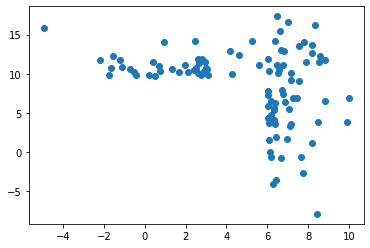

In [4]:
thres = np.quantile(samples_origin, 0.95,axis=0)

cond = (samples_origin[:,0] > thres[0] ) | (samples_origin[:,1] > thres[1] ) 
samples = samples_origin[cond,:]
plt.scatter(samples[:,0],samples[:,1] )

In [5]:
seed = 1234
rng = np.random.default_rng(seed)  # set seed for reproducibility (change/remove if you want)
idx = rng.permutation(len(samples))

split = int(0.8 * len(samples))
train_idx, val_idx = idx[:split], idx[split:]

train_samples = samples[train_idx]
val_samples   = samples[val_idx]

In [18]:
train_samples.shape

(78, 2)

In [6]:
def build_realnvp_flow(dim: int, num_layers: int, hidden_mult: int, device):
    """
    Builds a RealNVP-like flow using MaskedAffineFlow + ActNorm blocks.
    hidden_mult controls the middle layer width: hidden_mult * latent_size
    """
    base = nf.distributions.DiagGaussian(dim)
    latent_size = dim
    b = torch.Tensor([1 if i % 2 == 0 else 0 for i in range(latent_size)]).to(device)

    flows = []
    for i in range(num_layers):
        hidden = hidden_mult * latent_size
        s = nf.nets.MLP([latent_size, hidden, latent_size], init_zeros=True, output_fn='tanh')
        t = nf.nets.MLP([latent_size, hidden, latent_size], init_zeros=True, output_fn='tanh')
        if i % 2 == 0:
            flows += [nf.flows.MaskedAffineFlow(b, t, s)]
        else:
            flows += [nf.flows.MaskedAffineFlow(1 - b, t, s)]
        flows += [nf.flows.ActNorm(latent_size)]

    flow_model = nf.NormalizingFlow(base, flows).to(device)
    return flow_model

def train_one_setting(
    *,
    dim: int,
    num_layers: int,
    hidden_mult: int,
    device,
    train_samples,
    val_samples,
    seed: int = 1234,
    epochs: int = 200,
    batch_size: int = 64,
    patience: int = 100,
    min_delta: float = 0.0,
    weight_decay: float = 1e-5,
    lr_flow: float = 1e-2,
    lr_log_sigma: float = 1e-1,
    lr_theta: float = 1e-1,
):
    """
    Returns:
      result dict with:
        best_val, best_epoch, final_epoch, histories, and best_state (CPU tensors)
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    # tensors + loaders
    train_data = torch.tensor(np.asarray(train_samples), dtype=torch.float32, device=device)
    val_data   = torch.tensor(np.asarray(val_samples),   dtype=torch.float32, device=device)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True,  drop_last=False)
    val_loader   = DataLoader(val_data,   batch_size=batch_size, shuffle=False, drop_last=False)

    # build flow + wrapper model
    f_T_model = build_realnvp_flow(dim=dim, num_layers=num_layers, hidden_mult=hidden_mult, device=device)

    model = T_mGPD_NF(
        dim=dim,
        flow=f_T_model,
        device=device,
        s_min=-10,
        s_max=10,
        num_integration_points=1000,
        penalty_lambda=10000,
        fix_margin=False
    ).to(device)

    optimizer = torch.optim.Adam(
        [
            {'params': model.flow_model.parameters(), 'lr': lr_flow},
            {'params': model.data_transform.log_sigma, 'lr': lr_log_sigma},
            {'params': model.data_transform.theta,     'lr': lr_theta},
        ],
        weight_decay=weight_decay
    )
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

    best_val = float("inf")
    best_state = None
    best_epoch = -1
    bad_epochs = 0

    train_hist, val_hist = [], []

    torch.autograd.set_detect_anomaly(True)

    for epoch in range(epochs):
        # ---------------- TRAIN ----------------
        model.train()
        train_epoch_loss = 0.0
        train_count = 0

        for x_data in train_loader:
            batch_loss = model(x_data)

            if torch.isnan(batch_loss) or torch.isinf(batch_loss):
                print(f"[Grid] NaN/Inf in TRAIN | layers={num_layers} hidden_mult={hidden_mult} epoch={epoch}")
                bad_epochs = patience  # force stop
                break

            optimizer.zero_grad(set_to_none=True)
            batch_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            bsz = x_data.shape[0]
            train_epoch_loss += batch_loss.item() * bsz
            train_count += bsz

        train_epoch_loss = train_epoch_loss / max(train_count, 1)
        train_hist.append(train_epoch_loss)

        # ---------------- VALIDATION ----------------
        model.eval()
        val_epoch_loss = 0.0
        val_count = 0
        with torch.no_grad():
            for x_val in val_loader:
                vloss = model(x_val)
                if torch.isnan(vloss) or torch.isinf(vloss):
                    print(f"[Grid] NaN/Inf in VAL | layers={num_layers} hidden_mult={hidden_mult} epoch={epoch}")
                    bad_epochs = patience
                    break
                bsz = x_val.shape[0]
                val_epoch_loss += vloss.item() * bsz
                val_count += bsz

        val_epoch_loss = val_epoch_loss / max(val_count, 1)
        val_hist.append(val_epoch_loss)

        scheduler.step()

        # ---------------- EARLY STOPPING on VAL ----------------
        improved = (best_val - val_epoch_loss) > min_delta
        if improved:
            best_val = val_epoch_loss
            best_epoch = epoch
            bad_epochs = 0
            # keep best weights for this hyperparam setting
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        else:
            bad_epochs += 1

        # optional logging per epoch (comment out if too chatty)
        # print(f"[Grid] layers={num_layers:2d} hidden_mult={hidden_mult:2d} "
        #       f"epoch={epoch+1:3d}/{epochs} train={train_epoch_loss:.6f} val={val_epoch_loss:.6f}")

        if bad_epochs >= patience:
            break

    result = {
        "num_layers": num_layers,
        "hidden_mult": hidden_mult,
        "best_val": float(best_val),
        "best_epoch": int(best_epoch),
        "final_epoch": int(epoch),
        "train_history": train_hist,
        "val_history": val_hist,
        "best_state": best_state,  # CPU tensors
    }
    return result

# ----------------------------
# DEFINE YOUR GRID
# ----------------------------
num_layers_grid = [4, 8, 12, 16]      # example; edit as desired
hidden_mult_grid = [2, 4, 6, 8]          # middle layer = hidden_mult * latent_size

# ----------------------------
# RUN GRID SEARCH
# ----------------------------
grid_results = []
best_overall = None

dim = 2
batch_size = 64
epochs = 200
patience = 50          # how many epochs w/o improvement before stopping
min_delta = 0.0        # minimum improvement to reset patience
best_val = float("inf")
best_state = None
bad_epochs = 0

for nl in num_layers_grid:
    for hm in hidden_mult_grid:
        print(f"\n=== Training setting: num_layers={nl}, hidden_mult={hm} ===")
        res = train_one_setting(
            dim=dim,
            num_layers=nl,
            hidden_mult=hm,
            device=device,
            train_samples=train_samples,
            val_samples=val_samples,
            seed=seed,
            epochs=epochs,
            batch_size=batch_size,
            patience=patience,
            min_delta=min_delta,
            weight_decay=1e-5,
            lr_flow=1e-2,
            lr_log_sigma=1e-1,
            lr_theta=1e-1,
        )
        grid_results.append(res)

        print(f"--> best_val={res['best_val']:.6f} at epoch {res['best_epoch']+1}")

        if (best_overall is None) or (res["best_val"] < best_overall["best_val"]):
            best_overall = res

# ----------------------------
# REPORT + RESTORE BEST SETTING
# ----------------------------
print("\n====================")
print("GRID SEARCH COMPLETE")
print("====================")
print(f"Best hyperparams: num_layers={best_overall['num_layers']}, hidden_mult={best_overall['hidden_mult']}")
print(f"Best val loss: {best_overall['best_val']:.6f} (epoch {best_overall['best_epoch']+1})")



=== Training setting: num_layers=4, hidden_mult=2 ===


--> best_val=6.459525 at epoch 120

=== Training setting: num_layers=4, hidden_mult=4 ===
--> best_val=6.496976 at epoch 121

=== Training setting: num_layers=4, hidden_mult=6 ===
--> best_val=6.478784 at epoch 134

=== Training setting: num_layers=4, hidden_mult=8 ===
--> best_val=6.497544 at epoch 111

=== Training setting: num_layers=8, hidden_mult=2 ===
--> best_val=6.524191 at epoch 90

=== Training setting: num_layers=8, hidden_mult=4 ===
--> best_val=6.481613 at epoch 130

=== Training setting: num_layers=8, hidden_mult=6 ===
--> best_val=6.455711 at epoch 139

=== Training setting: num_layers=8, hidden_mult=8 ===
--> best_val=6.494479 at epoch 104

=== Training setting: num_layers=12, hidden_mult=2 ===
--> best_val=6.534851 at epoch 142

=== Training setting: num_layers=12, hidden_mult=4 ===
--> best_val=6.520883 at epoch 138

=== Training setting: num_layers=12, hidden_mult=6 ===
--> best_val=6.495015 at epoch 126

=== Training setting: num_layers=12, hidden_mult=8 ===
--> bes

In [20]:
pd.DataFrame({'num_layers':[a['num_layers'] for a in grid_results],
              'hidden_mult': [a['hidden_mult'] for a in grid_results],
              'best_val': [round(a['best_val'],2) for a in grid_results],
              'best_epoch': [a['best_epoch'] for a in grid_results], })

,num_layers,hidden_mult,best_val,best_epoch
0,4,2,6.46,119
1,4,4,6.50,120
2,4,6,6.48,133
3,4,8,6.50,110
4,8,2,6.52,89
5,8,4,6.48,129
6,8,6,6.46,138
7,8,8,6.49,103
8,12,2,6.53,141
9,12,4,6.52,137


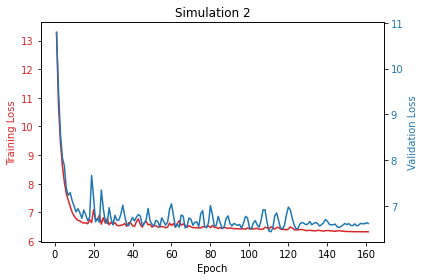

In [7]:
fig, ax1 = plt.subplots()
epochs = range(1, len(best_overall['train_history']) + 1)
color1 = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss', color=color1)
ax1.plot(epochs, best_overall['train_history'], color=color1, label='Training Loss')
ax1.tick_params(axis='y', labelcolor=color1)

# Validation loss is calculated every 20 epochs.
# Create a list of epochs corresponding to validation measurements

# Create a second y-axis for validation loss
ax2 = ax1.twinx()
color2 = 'tab:blue'
ax2.set_ylabel('Validation Loss', color=color2)
ax2.plot(epochs, best_overall['val_history'], color=color2, label='Validation Loss')
ax2.tick_params(axis='y', labelcolor=color2)

plt.title('Simulation 2')


# sns.set(style="ticks",font_scale=1)
plt.tight_layout()
plt.savefig(dir_out + 'Plots/'+'Train_val_loss_simulation_2.pdf',bbox_inches='tight')
plt.show()

#### Simulate data from Equation (19) and fit a GPDFlow on the threshold exceedance part. Repeat for 100 times 

In [8]:
n_samples = 1200
n_experiments = 100
seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU setups


dim = 2
base = nf.distributions.DiagGaussian(dim)

hidden_mult = best_overall['hidden_mult']
num_layers = best_overall['num_layers']
epochs = 200
best_epoch = best_overall['best_epoch']

torch.manual_seed(0)

latent_size = dim
b = torch.Tensor([1 if i % 2 == 0 else 0 for i in range(latent_size)])
flows = []
for i in range(num_layers):
    s = nf.nets.MLP([latent_size, hidden_mult * latent_size, latent_size], init_zeros=True, output_fn='tanh')
    t = nf.nets.MLP([latent_size, hidden_mult * latent_size, latent_size], init_zeros=True, output_fn='tanh')
    if i % 2 == 0:
        flows += [nf.flows.MaskedAffineFlow(b, t, s)]
    else:
        flows += [nf.flows.MaskedAffineFlow(1 - b, t, s)]
    flows += [nf.flows.ActNorm(latent_size)]


f_T_model = nf.NormalizingFlow(base, flows)
f_T_model = f_T_model.to(device)

batch_size = 64
loss_history = []


model = T_mGPD_NF(dim=dim, flow =f_T_model, device=device, s_min=-10,
                  s_max = 10, num_integration_points=1000, penalty_lambda=10000, fix_margin=False)

optimizer = torch.optim.Adam([
    {'params': model.flow_model.parameters(), 'lr': 1e-2},  # Flow layers
    {'params': model.data_transform.log_sigma, 'lr': 1e-1},  # Faster for log_sigma
    {'params': model.data_transform.theta, 'lr': 1e-1}       # Faster for gamma
], weight_decay = 1e-5 )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)


for i in range(n_experiments):
    Gumble = pv.Bicop(pv.BicopFamily.gumbel, parameters=np.array([[1.3]]))
    cop = Gumble
    # print(cop)

    U = cop.simulate(n_samples, seeds = np.array([seed+i, seed+i+1]))

    alpha = 2.0
    beta  = 1.0  # scale


    margin1 = norm.ppf(U[:,0], loc=1, scale=3)
    margin2 = norm.ppf(U[:,1], loc=2, scale=5)

    samples_origin = np.stack([margin1,margin2],axis=1)
    # sns.pairplot(pd.DataFrame(samples_origin),diag_kws={'bins': 10})

    thres = np.quantile(samples_origin, 0.95,axis=0)

    cond = (samples_origin[:,0] > thres[0] ) | (samples_origin[:,1] > thres[1] ) 
    samples = samples_origin[cond,:]

    thres = thres.reshape(1,-1)
    samples = samples - thres
    print(samples.shape)

    data = torch.tensor(samples, dtype=torch.float, device = device)
    print(data.shape)

    memory = torch.cuda.memory_allocated(device) /10**9
    print('{:.2f}G GPU memory allocated'.format(memory))


    Training_Data = DataLoader(data, batch_size=batch_size, shuffle=True)
    torch.autograd.set_detect_anomaly(True)

    for epoch in range(epochs):
        epoch_loss = 0.0
        
        for x_data in Training_Data:
            # Sample a batch of data from h_U

            batch_loss = model(x_data)

            # Backpropagation
            optimizer.zero_grad()
            batch_loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)


            optimizer.step()

            # Record loss
            loss_history.append(batch_loss.item())
            epoch_loss += batch_loss.item()

            if torch.isnan(batch_loss) or torch.isinf(batch_loss):
                print("NaN or Inf detected!")
                break

        # Debugging: Print shapes

        scheduler.step()
        if epoch == best_epoch:
            break
    torch.save(model.state_dict(), dir_out + f'Scenairo_2_model_2D_1200_{i}.pt')
    with open(dir_out + f'data_2D_10k_{i}.npy', 'wb') as f:
        np.save(f, samples_origin)
        np.save(f, thres)
    print(f"Completed Experiment {i} \n")



(98, 2)
torch.Size([98, 2])
0.02G GPU memory allocated


Completed Experiment 0 

(101, 2)
torch.Size([101, 2])
0.02G GPU memory allocated
Completed Experiment 1 

(99, 2)
torch.Size([99, 2])
0.02G GPU memory allocated
Completed Experiment 2 

(104, 2)
torch.Size([104, 2])
0.02G GPU memory allocated
Completed Experiment 3 

(104, 2)
torch.Size([104, 2])
0.02G GPU memory allocated
Completed Experiment 4 

(98, 2)
torch.Size([98, 2])
0.02G GPU memory allocated
Completed Experiment 5 

(101, 2)
torch.Size([101, 2])
0.02G GPU memory allocated
Completed Experiment 6 

(96, 2)
torch.Size([96, 2])
0.02G GPU memory allocated
Completed Experiment 7 

(99, 2)
torch.Size([99, 2])
0.02G GPU memory allocated
Completed Experiment 8 

(99, 2)
torch.Size([99, 2])
0.02G GPU memory allocated
Completed Experiment 9 

(106, 2)
torch.Size([106, 2])
0.02G GPU memory allocated
Completed Experiment 10 

(109, 2)
torch.Size([109, 2])
0.02G GPU memory allocated
Completed Experiment 11 

(101, 2)
torch.Size([101, 2])
0.02G GPU memory allocated
Completed Experiment 12 

In [76]:
model

T_mGPD_NF(
  (data_transform): DataTransform()
  (flow_model): NormalizingFlow(
    (q0): DiagGaussian()
    (flows): ModuleList(
      (0): MaskedAffineFlow(
        (s): MLP(
          (net): Sequential(
            (0): Linear(in_features=5, out_features=40, bias=True)
            (1): LeakyReLU(negative_slope=0.0)
            (2): Linear(in_features=40, out_features=5, bias=True)
            (3): Tanh()
          )
        )
        (t): MLP(
          (net): Sequential(
            (0): Linear(in_features=5, out_features=40, bias=True)
            (1): LeakyReLU(negative_slope=0.0)
            (2): Linear(in_features=40, out_features=5, bias=True)
            (3): Tanh()
          )
        )
      )
      (1): ActNorm()
      (2): MaskedAffineFlow(
        (s): MLP(
          (net): Sequential(
            (0): Linear(in_features=5, out_features=40, bias=True)
            (1): LeakyReLU(negative_slope=0.0)
            (2): Linear(in_features=40, out_features=5, bias=True)
       

#### Calculate the estimated $\chi(q)$ by Monte Carlo and compare it with the theoretical $\chi$

In [9]:
n_experiments = 100
n_model_sample = 1000

seed = 1234
Gumble = pv.Bicop(pv.BicopFamily.gumbel, parameters=np.array([[1.3]]))
cop = Gumble
# print(cop)


probs = np.linspace(0.80, 0.996, 100)

Cuu = cop.cdf(np.stack([probs,probs],axis=1))
chi_theorical = (1 - 2*probs + Cuu)/(1-probs)

probs = np.linspace(0.80, 0.996, 100)
# Compute lambda_u for each quantile

# Step 2: Generate samples and compute their KDEs
sample_chi = []

for _ in range(n_experiments):  # Step 3: Repeat 200 times
    model.load_state_dict(torch.load(dir_out + f'Scenairo_2_model_2D_1200_{_}.pt', weights_only=True))
    model.eval()
    samples_obs, samples_std, samples_T= model.sample(n_model_sample)
    sampled_data = samples_obs.cpu().data.numpy()
    sample_chi.append( [cf.empirical_upper_tail_dependence(sampled_data, p) for p in probs])


# Step 3: Calculate the 95% credible interval for the KDE of the samples
sample_chi = np.array(sample_chi)
lower_bound = np.percentile(sample_chi, 2.5, axis=0)
upper_bound = np.percentile(sample_chi, 97.5, axis=0)
mean = np.mean(sample_chi, axis=0)



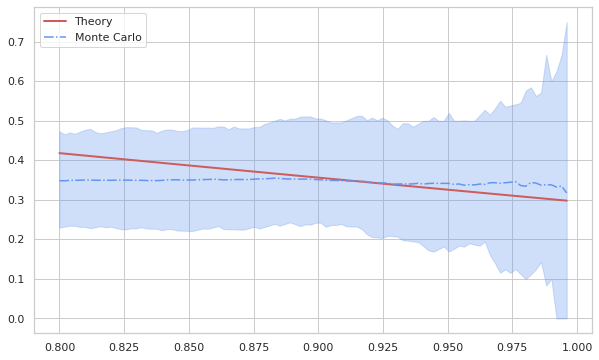

In [10]:
# Step 4: Plot the KDE of the data and the credible intervals with Seaborn
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the KDE of the data
sns.lineplot(x=probs, y=chi_theorical, label='Theory', color='indianred', linewidth=2)
# plt.hlines(y=chi_theorical, xmin=0.99, xmax=1, color='darkorange', linewidth=3)
# Plot the credible intervals
sns.lineplot(x=probs, y=mean, linestyle='dashdot', color='cornflowerblue', label='Monte Carlo', linewidth=1.5)
# sns.lineplot(x=probs, y=lower_bound, linestyle='--', color='cornflowerblue', label='95% BootStrap CI', linewidth=1.5)
# sns.lineplot(x=probs, y=upper_bound, linestyle='--', color='cornflowerblue', linewidth=1.5)
ax.fill_between(probs, lower_bound, upper_bound, color='cornflowerblue', alpha=0.3, label='95% Credible Interval')

#### Compute the $\mathbb{P}(Y_1 < q_{1,\alpha}, Y_2>q_{2,0.99})$ and compare the theoretical value with the estimated value 

In [11]:
n_experiments = 100
n_model_sample = 100000
n_bootstrap = 100

u1 = np.arange(0.5,1,0.1)
u2 = np.array([0.99]*len(u1))
prob_non_exceed = cop.cdf(np.stack([u1,u2],axis=1))

prob_partial_exceed = {}
prob = np.log(u1 - prob_non_exceed)
for i in range(len(u1)):
    prob_partial_exceed[f'P(X1<q{u1[i]:.2f}, X2>q{u2[i]:.3f})'] = prob[i]


x1 = norm.ppf(u1, loc=1, scale=3)
# x2 = expon.ppf(u2,  scale =5 )
x2 = norm.ppf(u2, loc=2, scale=5)

prob_exceed_dict =   dict([(f'P(X1<q{u1[i]:.2f}, X2>q{u2[i]:.3f})', []) for i in range(len(x1))])
for _ in range(n_experiments): 
    model.load_state_dict(torch.load(dir_out + f'Scenairo_2_model_2D_1200_{_}.pt', weights_only=True))
    model.eval()
    with torch.no_grad():
        samples_obs, samples_std, samples_T= model.sample(n_model_sample)
    

    with open(dir_out + f'data_2D_10k_{i}.npy', 'rb') as f:
        samples_origin = np.load(f)
        thres = np.load(f)
    samples_data = samples_obs.cpu().data.numpy() + thres
    prob_exceed = np.mean((samples_origin[:,0]>thres.flatten()[0]) | (samples_origin[:,1]>thres.flatten()[1] ) )
    for i in range(len(x1)):
        val = np.log(cf.empirical_survival(samples_data, [x1[i],x2[0]], "<>"))+ np.log(prob_exceed)
        prob_exceed_dict[f'P(X1<q{u1[i]:.2f}, X2>q{u2[i]:.3f})'].append(val)

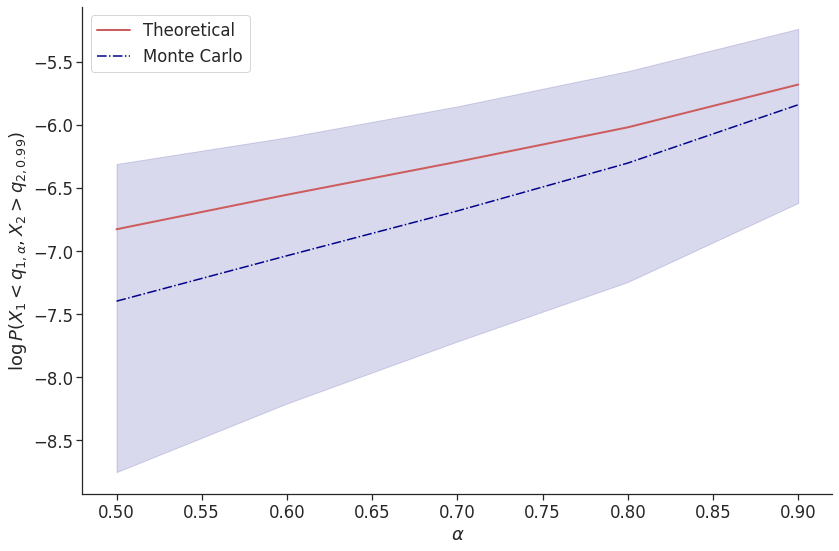

In [13]:
df = pd.DataFrame(prob_exceed_dict)
prob_partial_exceed_list = [value for key, value in prob_partial_exceed.items() ]

mean = np.mean(df,axis=0)
lower_bound = np.quantile(df, 0.025, axis=0)
upper_bound = np.quantile(df, 0.975, axis=0)

sns.set(style="ticks",font_scale=1.5)
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x=u1, y=prob_partial_exceed_list, label='Theoretical', color='indianred', linewidth=2)

sns.lineplot(x=u1, y=mean, linestyle='dashdot', color='darkblue', label='Monte Carlo', linewidth=1.5)

ax.fill_between(u1, lower_bound, upper_bound, color='darkblue', alpha=0.15, label='95% Credible Interval')
plt.ylabel(r'$\log P(X_1<q_{1,\alpha}, X_2>q_{2,0.99})$')
plt.xlabel(r'$\alpha$')
sns.despine()
plt.tight_layout()
plt.savefig(dir_out + 'Plots/'+f'Simulation_2_threshold_exceed_prob.pdf',bbox_inches='tight')

#### Visualize the contour plot of the theoretical density

/home/pgrad2/2448355h/.local/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


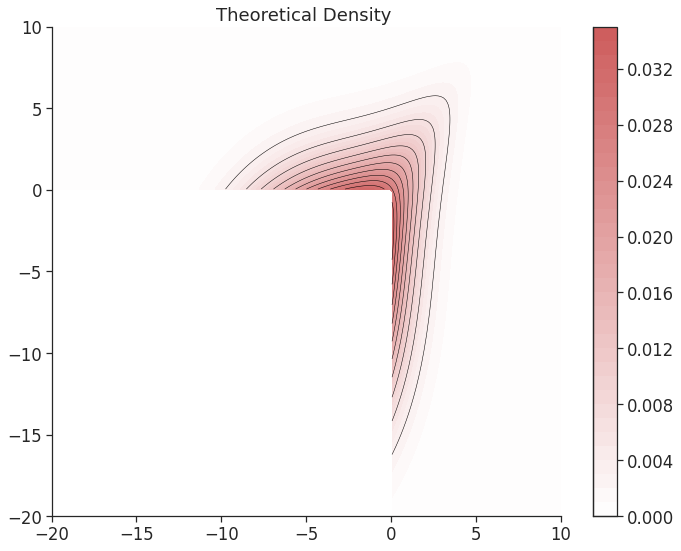

In [14]:
grid_size = 200
xx, yy = torch.meshgrid(torch.linspace(-20, 10, grid_size), torch.linspace(-20, 10, grid_size))
thres_x = norm.ppf(0.95, loc=1, scale=3)
thres_y = norm.ppf(0.95, loc=2, scale=5)
thres = (thres_x, thres_y)

xx_np = xx.numpy() + thres_x
yy_np = yy.numpy() + thres_y

# Define the Gumbel copula with parameter 1.3.
Gumble = pv.Bicop(pv.BicopFamily.gumbel, parameters=np.array([[1.3]]))
cop = Gumble

# Compute marginal CDFs for the two normals:
# Margin 1: Normal(loc=1, scale=3)
# Margin 2: Normal(loc=2, scale=5)
u1 = norm.cdf(xx_np, loc=1, scale=3)
u2 = norm.cdf(yy_np, loc=2, scale=5)
u = np.column_stack([u1.ravel(), u2.ravel()])

# Compute the copula density over the grid.
copula_density = cop.pdf(u).reshape(xx_np.shape)

# Compute the marginal PDFs.
f1 = norm.pdf(xx_np, loc=1, scale=3)
f2 = norm.pdf(yy_np, loc=2, scale=5)

prob_thres_exceedance = 1- np.mean(cop.cdf(np.array([[0.95,0.95],[0.95,0.95]])))


# The joint density is given by: density = copula_density * f1 * f2.
density = copula_density * f1 * f2/prob_thres_exceedance



# (Optional: if you want to force density to 0 where both x and y are negative.)
density[(xx_np < thres_x) & (yy_np < thres_y)] = 0

# ---- Define Thresholds and Masking ----
# Define thresholds for each margin.

# Create a mask: only keep points where at least one margin exceeds its threshold.
mask = (xx_np >= thres_x) | (yy_np >= thres_y)
density_masked = np.where(mask, density, np.nan)  # or use 0 instead of np.nan if preferred

# Translate the grid so that the thresholds align at zero.
xx_trans = xx_np - thres_x
yy_trans = yy_np - thres_y

# ---- Plotting ----
# Create a custom colormap: white corresponds to density 0 and blue to maximum density.
cmap = LinearSegmentedColormap.from_list('custom_blue', ['white', 'indianred'], N=256)

sns.set(style="ticks",font_scale=1.5)
plt.figure(figsize=(10, 8))
# Create a filled contour plot with 50 levels.
num_levels = 50
levels = np.unique(np.linspace( 1e-5, 0.035, num_levels).round(3))
contour_filled = plt.contourf(xx_trans, yy_trans, density_masked, levels=levels, cmap=cmap, )
# Optionally, overlay contour lines for enhanced visualization.
plt.contour(xx_trans, yy_trans, density_masked, levels=10, colors='black', linewidths=0.5)
plt.title('Theoretical Density ')
plt.colorbar(contour_filled)
sns.despine()
plt.tight_layout()
plt.savefig(dir_out + 'Plots/'+f'Simulation_2_theoretical_density.pdf',bbox_inches='tight')
plt.show()

#### Visualize the contour plot of the estimated density

In [15]:
grid_size = 200
xx, yy = torch.meshgrid(torch.linspace(-20, 10, grid_size), torch.linspace(-20, 10, grid_size))
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
zz = zz.to(device)

log_prob = torch.zeros((n_experiments,grid_size,grid_size))
with torch.no_grad():
    for _ in range(n_experiments):
        model.load_state_dict(torch.load(dir_out + f'Scenairo_2_model_2D_1200_{_}.pt', weights_only=True))
        log_prob[_] = model.log_prob(zz).to('cpu').view(*xx.shape)
log_prob = torch.mean(log_prob, axis=0)
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = np.nan
prob[(xx < 0) & (yy < 0)] = np.nan


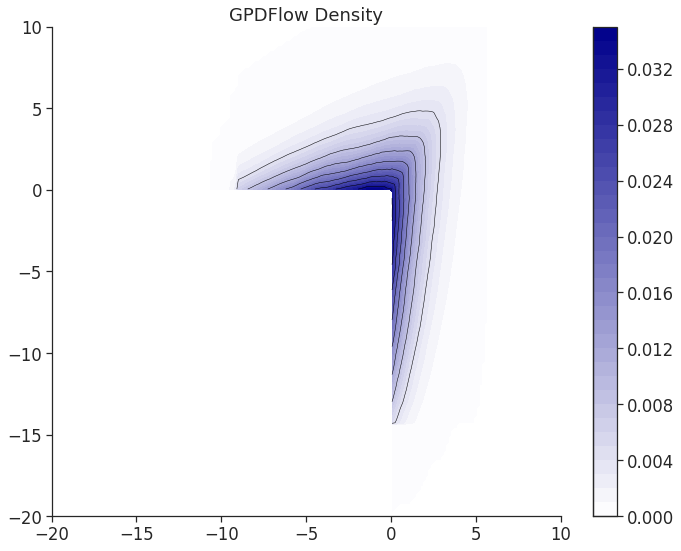

In [16]:

cmap = LinearSegmentedColormap.from_list('custom_blue', ['white', 'darkblue'], N=256)
density_threshold = 1e-6
density_masked_cleaned = np.where(prob < density_threshold, np.nan, prob)
sns.set(style="ticks",font_scale=1.5)
plt.figure(figsize=(10, 8))
contour_filled = plt.contourf(xx, yy, density_masked_cleaned, levels=levels, cmap=cmap)
# Optionally, overlay contour lines for enhanced visualization.
plt.contour(xx, yy, density_masked_cleaned, levels=10, colors='black', linewidths=0.5)
plt.title('GPDFlow Density')
plt.colorbar(contour_filled)
sns.despine()
plt.tight_layout()
plt.savefig(dir_out + 'Plots/'+f'Simulation_2_GPDFlow_density.pdf',bbox_inches='tight')
plt.show()